In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

2.6.0


In [2]:
train  = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
# Create the X_train and y_train variables 
x_train = train.drop('label', axis=1)
y_train = train.label
print(f'x_train = {x_train.shape}')
print(f'test = {test.shape}')

x_train = (42000, 784)
test = (28000, 784)


In [4]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [5]:
# Normalize the data 
x_train = x_train / 255.0
test = test / 255.0

# Reshape the data
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# label encoding 
y_train = to_categorical(y_train, num_classes = 10)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=5)

print(f'x_train = {x_train.shape}')
print(f'test = {test.shape}')

x_train = (33600, 28, 28, 1)
test = (28000, 28, 28, 1)


In [6]:
x_train[0].shape

(28, 28, 1)

In [7]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

2021-11-05 11:03:29.449231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:03:29.558571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:03:29.559305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:03:29.560613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
# Now that the model is so large, it's useful to summarize it
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [11]:
# Set a learning rate annealer
from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,  
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
epochs = 50
batch_size = 90

history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

2021-11-05 11:03:32.594365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-05 11:03:34.658029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


373/373 [==============================] - 19s 30ms/step - loss: 0.3892 - accuracy: 0.9141 - val_loss: 0.7734 - val_accuracy: 0.8123
Epoch 2/50
373/373 [==============================] - 12s 32ms/step - loss: 0.0880 - accuracy: 0.9763 - val_loss: 0.0867 - val_accuracy: 0.9746
Epoch 3/50
373/373 [==============================] - 11s 31ms/step - loss: 0.0673 - accuracy: 0.9817 - val_loss: 0.0695 - val_accuracy: 0.9806
Epoch 4/50
373/373 [==============================] - 11s 30ms/step - loss: 0.0607 - accuracy: 0.9842 - val_loss: 0.0532 - val_accuracy: 0.9868
Epoch 5/50
373/373 [==============================] - 12s 31ms/step - loss: 0.0534 - accuracy: 0.9857 - val_loss: 0.0353 - val_accuracy: 0.9910
Epoch 6/50
373/373 [==============================] - 11s 30ms/step - loss: 0.0484 - accuracy: 0.9879 - val_loss: 0.0442 - val_accuracy: 0.9896
Epoch 7/50
373/373 [==============================] - 12s 32ms/step - loss: 0.0416 - accuracy: 0.9896 - val_loss: 0.0384 - val_accuracy: 0.9910
Epo

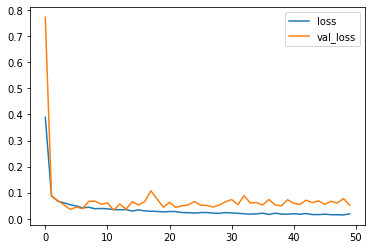

In [13]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

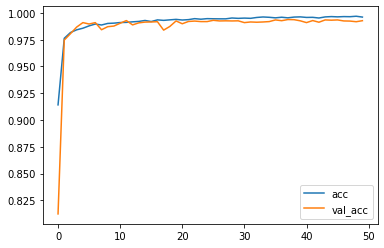

In [14]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [15]:
res = model.predict(test)
res = np.argmax(res,axis = 1)
res = pd.Series(res, name="Label")
submission = pd.concat([pd.Series(range(1 ,28001) ,name = "ImageId"),   res],axis = 1)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [16]:
submission.to_csv('submission.csv',index=False)
